# TUGAS PERTAMA: Pengembangan Machine Learning (DICODING)
<a href='https://www.linkedin.com/in/louis-widi-anandaputra-90008815a/' target='_blank'>Louis Widi Anandaputra</a>
## Membuat Model NLP dengan TensorFlow
Berikut kriteria submission yang harus dipenuhi:
- Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
- Harus menggunakan LSTM dalam arsitektur model.
- Harus menggunakan model sequential.
- Validation set sebesar 20% dari total dataset.
- Harus menggunakan Embedding.
- Harus menggunakan fungsi tokenizer.
- Akurasi dari model minimal 75% pada train set dan validation set.

## Persiapan Library dan Fungsi

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [97]:
# Fungsi untuk pre-processing text
def text_cleaning(text):
    """
    Clean the text using NLP and regular expressions
    
    text = Uncleaned text
    """
    text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
    text = re.sub(r'<.*?>', '', text)
    text = ''.join([char for char in text if char in string.printable])
    text = re.sub(r'@\S+', 'USER', text)
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

Data akan menggunakan data sentimen analisis yang berasal dari <a href='https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset' target="_blank">Kaggle</a>. Pada data asli terdapat 2 tipe data, yakni data yang berasal dari Reddit dan dari Twitter (sekarang X). Data yang akan digunakan adalah data yang berasal dari Twitter. Data berjumlah lebih dari 160.000 unggahan yang memiliki label sentimen.

<a href='https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset' target="_blank"><img src='image.png'></a>


## Pre-Processing

In [98]:
df = pd.read_csv('dataset/Twitter_Data.csv')

In [99]:
df.tail()

,clean_text,category
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0
162979,have you ever listen about like gurukul where ...,1.0


Terdapat 162.979 data awal yang akan digunakan.

In [100]:
# Checking Statistical Summary of data
df.describe(include='all')

,clean_text,category
count,162976,162973.000000
unique,162976,NaN
top,when modi promised “minimum government maximum...,NaN
freq,1,NaN
mean,NaN,0.225436
std,NaN,0.781279
min,NaN,-1.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [101]:
df['category'].unique()

array([-1.,  0.,  1., nan])

Terdapat beberapa missing values yang dapat diproses.

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


Missing values tidak terlalu banyak, sehingga data dapat dihilangkan saja, data akan tetap memiliki jumlah lebih dari 160.000

In [103]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


In [104]:
df.duplicated().sum()

0

In [105]:
df["clean_text"] = df["clean_text"].apply(text_cleaning)
df

,clean_text,category
0,modi promised minimum government maximum gover...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporters prefix chowkidar names modi ...,1.0
4,answer among powerful world leader today trump...,1.0
...,...,...
162975,456 crores paid neerav modi recovered congress...,-1.0
162976,dear rss terrorist payal gawar modi killing 10...,-1.0
162977,cover interaction forum left,0.0
162978,big project came india modi dream project happ...,0.0


In [106]:
# Mapping kategori sentimen
encode = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}
df['category'] = df['category'].map(encode)

In [111]:
df['category']

0         Negative
1          Neutral
2         Positive
3         Positive
4         Positive
            ...   
162975    Negative
162976    Negative
162977     Neutral
162978     Neutral
162979    Positive
Name: category, Length: 162969, dtype: object

## EDA + Processing Lanjutan

Text(0.5, 1.0, 'Distribusi Sentimen')

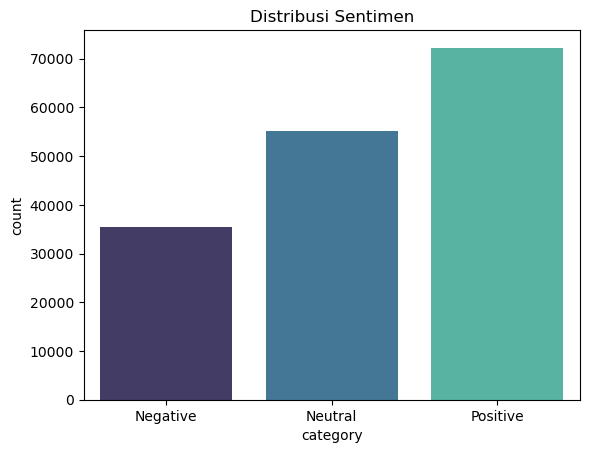

In [114]:
sns.countplot(data = df, x = 'category', palette='mako')
plt.title("Distribusi Sentimen")

Terlihat data yang imbalance, akan dilakukan proses balancing dengan mengambil data pada jumlah yang sama dengan kelas negative.

In [147]:
# Pemisahan data
df_class_0 = df[df['category'] == 'Negative']
df_class_1 = df[df['category'] == 'Neutral']
df_class_2 = df[df['category'] == 'Positive']

# Kelas yang akan digunakan untuk balancing
num_samples_to_keep = len(df_class_0)

# Sample sebuah subset dari kelas mayoritas (class 1)
df_class_1_subset = df_class_1.sample(n=num_samples_to_keep, random_state=42)

# Sample sebuah subset dari kelas mayoritas (class 2)
df_class_2_subset = df_class_2.sample(n=num_samples_to_keep, random_state=42)


df_balanced = pd.concat([df_class_0, df_class_1_subset, df_class_2_subset])


df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df = df_balanced

Text(0.5, 1.0, 'Distribusi Sentimen (setelah balancing)')

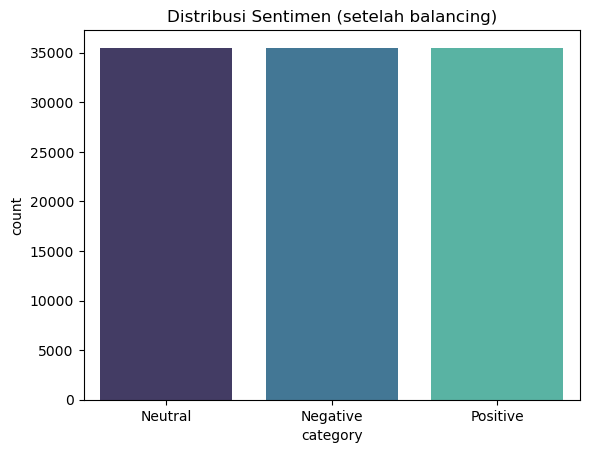

In [177]:
sns.countplot(data = df, x = 'category', palette='mako')
plt.title("Distribusi Sentimen (setelah balancing)")

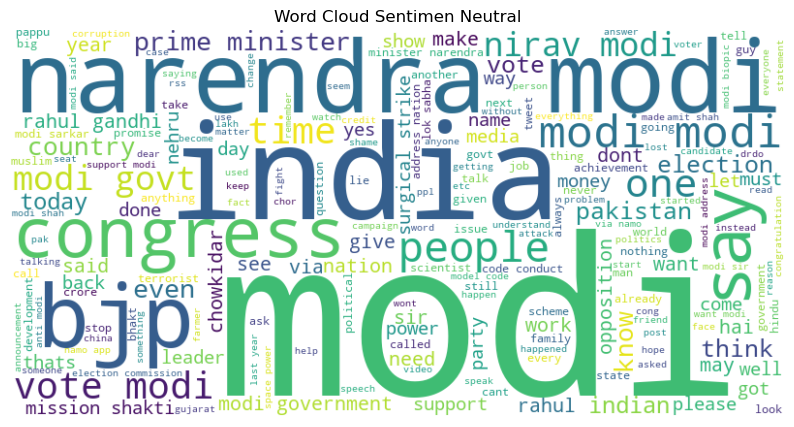

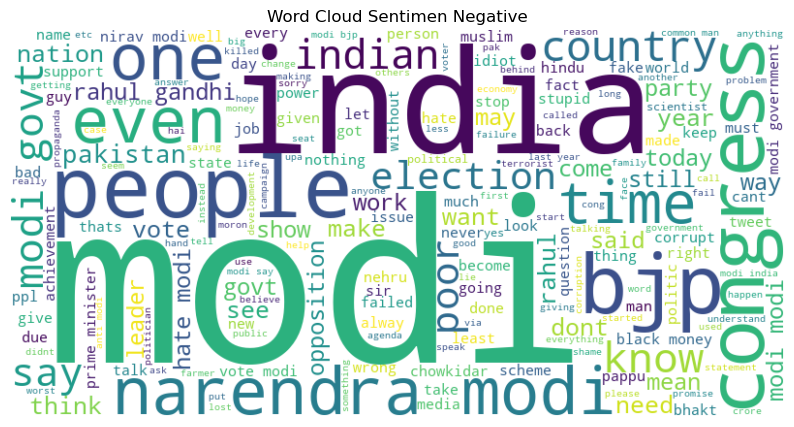

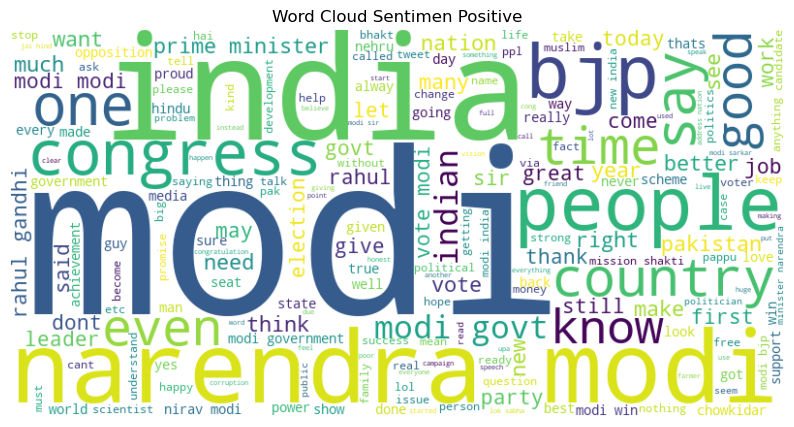

In [149]:
for category in df['category'].unique():
    text = " ".join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')

    plt.title(f'Word Cloud Sentimen {category}')
    plt.axis("off")
    plt.show()

## Pelatihan
### Persiapan Data

In [150]:
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru.columns

Index(['clean_text', 'Negative', 'Neutral', 'Positive'], dtype='object')

In [151]:
text = df_baru['clean_text'].values
label = df_baru[['Negative', 'Neutral', 'Positive']].values

In [152]:
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2, random_state=42)

In [154]:
max_words = 10000  

tokenizer = Tokenizer(num_words=max_words, oov_token='x')
tokenizer.fit_on_texts(text_latih) 
tokenizer.fit_on_texts(text_test)
 
sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

### Persiapan Model dan Pelatihan

In [161]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [162]:
num_epochs = 5
history = model.fit(padded_latih, label_latih, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=2)

Epoch 1/5
2664/2664 - 85s - loss: 0.4694 - accuracy: 0.8200 - val_loss: 0.3116 - val_accuracy: 0.9078 - 85s/epoch - 32ms/step
Epoch 2/5
2664/2664 - 92s - loss: 0.2768 - accuracy: 0.9167 - val_loss: 0.3158 - val_accuracy: 0.9096 - 92s/epoch - 35ms/step
Epoch 3/5
2664/2664 - 82s - loss: 0.2284 - accuracy: 0.9279 - val_loss: 0.3104 - val_accuracy: 0.9104 - 82s/epoch - 31ms/step
Epoch 4/5
2664/2664 - 82s - loss: 0.1792 - accuracy: 0.9408 - val_loss: 0.3368 - val_accuracy: 0.9044 - 82s/epoch - 31ms/step
Epoch 5/5
2664/2664 - 88s - loss: 0.1353 - accuracy: 0.9546 - val_loss: 0.4092 - val_accuracy: 0.8963 - 88s/epoch - 33ms/step


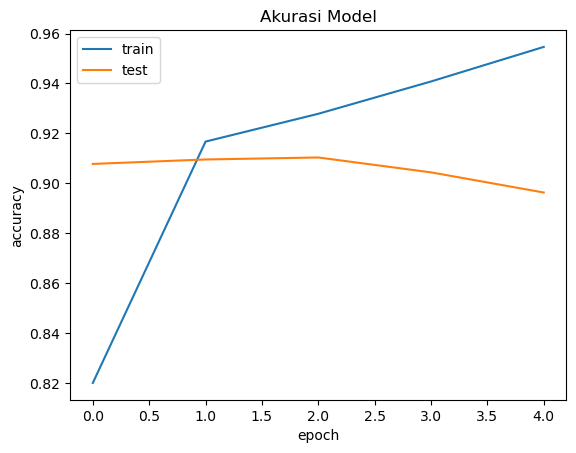

In [174]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

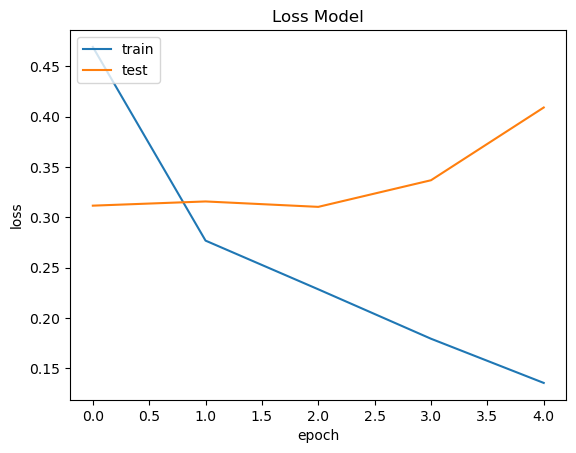

In [175]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Jika model dilanjutkan untuk training, maka akan terjadi overfitting. Langkah yang baik adalah untuk melakukan preprocessing serta EDA lebih menyeluruh untuk mendapatkan insight.

## Evaluasi

In [168]:
prediction = model.predict(padded_test)

666/666 [==============================] - 5s 7ms/step


In [169]:
# Assuming y_true contains true labels in one-hot encoded form and predictions is the output of the softmax layer
y_true_classes = np.argmax(label_test, axis=1)
y_pred_classes = np.argmax(prediction, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
classification_report_result = classification_report(y_true_classes, y_pred_classes)
confusion_matrix_result = confusion_matrix(y_true_classes, y_pred_classes)

In [171]:
print(classification_report_result)

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      7039
           1       0.92      0.92      0.92      7161
           2       0.91      0.87      0.89      7106

    accuracy                           0.90     21306
   macro avg       0.90      0.90      0.90     21306
weighted avg       0.90      0.90      0.90     21306



In [173]:
confusion_matrix_result

array([[6306,  300,  433],
       [ 359, 6616,  186],
       [ 617,  314, 6175]])

Dari confusion matrix, dapat dilihat bahwa sudah misclassification maksimal hanya sekitar 617 dan model dapat mengklasifikasikan dengan benar pada jumlah lebih dari 6000 data pada setiap kelas. Model dapat memprediksi kelas 1 (negatif) dengan baik sedangkan kurang dapat memprediksi kelas 0 (netral). Meski demikian, model ini telah mencapai <b>90%</b> akurasi yang sudah cukup baik ketika dites menggunakan seluruh data testing dengan f1 score pada setiap kelas yang lebih dari <b>87%</b>. Dengan data yang sudah balance, penggunaan macro dan weighted average juga sudah menunjukkan angka 90%, merepresentasikan kemampuan model yang meski hanya dilatih menggunakan 5 epoch, dapat memprediksi sentimen dengan baik.


© Louis Widi Anandaputra - 2023